# SeaSoar Processing

1. Load data
2. Identify upcasts and downcasts
3. Flag spurious pressure/data points by moving median filter
4. Bin sensor data to regular pressures
5. Flag outliers in signals

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

### Identify SeaSoar Datafiles

In [2]:
input.dir = '../../Models/SeaSoar/SeaSoar1/'

files = list.files(input.dir, full.names = FALSE)
files = files[grepl('.mat', files)]
files = files[!grepl('.rdata', files)]

length(files)

[1] 50

In [3]:
## Check file list
str(files)
files[1]

 chr [1:50] "FLT_DAT001.mat" "FLT_DAT002.mat" "FLT_DAT003.mat" ...


[1] "FLT_DAT001.mat"

In [4]:
## Read MAT file
get.data = function(input.dir, file) {
    data = readMat(paste0(input.dir, file), fixNames = TRUE)
    names = unlist(dimnames(data$data)[1])

    ## Partition up datea
    eng = as.data.frame(data$data[2:12]) # 1 Hz
    sensor = as.data.frame(data$data[13:36])
    colnames(sensor) = names[13:36]
    colnames(eng) = names[2:12]
    
    sensor$time = seq(from = eng$time[1], by = 1/24, length.out = nrow(sensor)) # 24 Hz sampling
    
    return(list(eng = eng, sensor = sensor))
}

#### Flag Outliers in pressure
flag.p.outliers = function(data, dp = 0.5, verbose = TRUE, window = 25) {
    l = which(abs(data$sensor$p - runmed(data$sensor$p, window)) > dp)
    
    data$sensor$p.FLAG = 1 # keep
    data$sensor$p.FLAG[l] = 3 # reject
    
    if (verbose) {
        n = length(l)
        perc = floor(length(l) / nrow(data$sensor)*1000)/10
        
        print(paste0('Flagging identified ', n, ' (', perc, '%) outliers.'))
    }
    data
}

#### Bin Data by pressure
bin.p = function(data, dp = 1) {
    ## Initial smoothing of signals
    #data = smooth.p(data)
    
    ## Create Bins
    data$sensor$p = floor((data$sensor$p + 0.5) / dp)
    data$sensor$n.bin = 0
    
    i = 1
    k = c(1,2, 4:25)
    while (i < nrow(data$sensor)) {
        delta.p = abs(diff(data$sensor$p[i:nrow(data$sensor)]))  # i refenced
        
        ## Find entries to average across
        l = which(cumsum(delta.p) == 0)
        l = c(i, l + i)
        
        data$sensor[i,k] = apply(data$sensor[l,k], 2, function(x) {median(x, na.rm = TRUE)})
        data$sensor$n.bin[i] = length(l)
        
        ## Update values and some housekepping
        if (length(l) > 1) { ## Need to update values
            l = l[l != i]
            data$sensor = data$sensor[-l,] ## Remove other values
        }
        i = i + 1
    }
    ## Finalize and return averaged data
    data$sensor$p = data$sensor$p * dp
    data
}

#### Just smooth data
smooth.p = function(data, dt = 5) {
    ## Smooth sensor data
    data$sensor = data$sensor[which(data$sensor$p.FLAG == 1),]
    temp = apply(data$sensor, 2, function(x){runmed(x, dt, endrule = 'median')})
    temp = apply(data$sensor, 2, function(x){ma(x, dt)})
    
    temp = as.data.frame(temp, col.names = colnames(data$sensor))
    temp = temp[-c(1,2),] # Remove NAs
    
    data$sensor = temp
    
    
    ## Smooth Eng data
    temp = apply(data$eng, 2, function(x){runmed(x, dt, endrule = 'median')})
    temp = apply(data$eng, 2, function(x){ma(x, dt)})
    
    temp = as.data.frame(temp, col.names = colnames(data$eng))
    temp = temp[-c(1,2),] # Remove NAs
    
    data$eng = temp
    
    ## Return
    data
}

combine.data.eng = function(data) {
    data$eng$t1 = 0
    data$eng$t2 = 0
    data$eng$p = 0
    data$eng$c1 = 0
    data$eng$c2 = 0
    data$eng$trans = 0
    data$eng$fl = 0
    data$eng$oxy = 0
    data$eng$oxyt = 0
    data$eng$v5 = 0
    data$eng$v6 = 0
    data$eng$wingpitch = 0
    data$eng$roll = 0
    data$eng$fishpitch = 0
    data$eng$proprpm = 0
    data$eng$modcount = 0
    data$eng$s1 = 0
    data$eng$s2 = 0
    data$eng$theta1 = 0
    data$eng$theta2 = 0
    data$eng$sigma1 = 0
    data$eng$sigma2 = 0
    data$eng$soundspeed1 = 0
    data$eng$soundspeed2 = 0
    data$eng$sensor.n = 0
    
    for (i in 1:nrow(data$eng)) {
        l = which(abs(data$eng$time[i] - data$sensor$time) < 0.5)
        
        if (length(l) > 0) {
            data$eng$t1[i] = median(data$sensor$t1[l])
            data$eng$t2[i] = median(data$sensor$t2[l])
            data$eng$p[i] = median(data$sensor$p[l])
            data$eng$c1[i] = median(data$sensor$c1[l])
            data$eng$c2[i] = median(data$sensor$c2[l])
            data$eng$trans[i] = median(data$sensor$trans[l])
            data$eng$fl[i] = median(data$sensor$fl[l])
            data$eng$oxy[i] = median(data$sensor$oxy[l])
            data$eng$oxyt[i] = median(data$sensor$oxyt[l])
            data$eng$v5[i] = median(data$sensor$v5[l])
            data$eng$v6[i] = median(data$sensor$v6[l])
            data$eng$wingpitch[i] = median(data$sensor$wingpitch[l])
            data$eng$roll[i] = median(data$sensor$roll[l])
            data$eng$fishpitch[i] = median(data$sensor$fishpitch[l])
            data$eng$proprpm[i] = median(data$sensor$proprpm[l])
            data$eng$modcount[i] = median(data$sensor$modcount[l])
            data$eng$s1[i] = median(data$sensor$s1[l])
            data$eng$s2[i] = median(data$sensor$s2[l])
            data$eng$theta1[i] = median(data$sensor$theta1[l])
            data$eng$theta2[i] = median(data$sensor$theta2[l])
            data$eng$sigma1[i] = median(data$sensor$sigma1[l])
            data$eng$sigma2[i] = median(data$sensor$sigma2[l])
            data$eng$soundspeed1[i] = median(data$sensor$soundspeed1[l])
            data$eng$soundspeed2[i] = median(data$sensor$soundspeed2[l])
            data$eng$sensor.n[i] = length(l)
        }
    }
    ## Strip sensor data
    data$sensor = 0
    data
}


combine.data.sensor = function(data) {
    data$sensor$lat = 0
    data$sensor$lon = 0
    data$sensor$cog = 0
    data$sensor$sog = 0
    data$sensor$heading = 0
    data$sensor$sow = 0
    data$sensor$bottomdepth = 0
    data$sensor$moogdrive = 0
    data$sensor$moogmonitor = 0
    data$sensor$tension = 0
    
    time.floor = floor(data$sensor$time)
    
    for (i in unique(time.floor)) {
        l = which(time.floor == i)
        l2 = which(data$eng$time == i)
        
        if(length(l) > 0 & length(l2) > 0) {
            l2 = l2[1]
            data$sensor$lat[l] = data$eng$lat[l2]
            data$sensor$lon[l] = data$eng$lon[l2]
            data$sensor$cog[l] = data$eng$cog[l2]
            data$sensor$sog[l] = data$eng$sog[l2]
            data$sensor$heading[l] = data$eng$heading[l2]
            data$sensor$sow[l] = data$eng$sow[l2]
            data$sensor$bottomdepth[l] = data$eng$bottomdepth[l2]
            data$sensor$moogdrive[l] = data$eng$moogdrive[l2]
            data$sensor$moogmonitor[l] = data$eng$moogmonitor[l2]
            data$sensor$tension[l] = data$eng$tension[l2]
        }
    }
    data$sensor
}

In [27]:
temp = get.data(input.dir, files[10])
#temp$sensor = combine.data.sensor(temp)
#temp = flag.p.outliers(temp, verbose = TRUE)

#temp = smooth.p(temp)
temp = bin.p(temp)
str(temp)

List of 2
 $ eng   :'data.frame':	6494 obs. of  11 variables:
  ..$ lat        : num [1:6494] 35.1 35.1 35.1 35.1 35.1 ...
  ..$ lon        : num [1:6494] -123 -123 -123 -123 -123 ...
  ..$ time       : num [1:6494] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
  ..$ cog        : num [1:6494] 157 156 156 156 156 ...
  ..$ sog        : num [1:6494] 9 9.1 9.2 9.2 9.3 9.3 9.3 9.2 9.1 9 ...
  ..$ heading    : num [1:6494] 152 152 152 152 152 ...
  ..$ sow        : num [1:6494] -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
  ..$ bottomdepth: num [1:6494] 3277 3277 3277 3277 3277 ...
  ..$ moogdrive  : num [1:6494] 24 24 24 24 24 24 24 24 24 24 ...
  ..$ moogmonitor: num [1:6494] 27.8 27.8 27.8 27.7 27.8 27.8 27.8 27.8 27.8 27.8 ...
  ..$ tension    : num [1:6494] 1972 1993 2019 2041 2047 ...
 $ sensor:'data.frame':	39259 obs. of  26 variables:
  ..$ t1         : num [1:39259] 11.1 11.1 11.1 11.1 11.1 ...
  ..$ t2         : num [1:39259] 11.1 11.1 11.1 11.1 11.1 ...
  ..$ p          : num [1:392

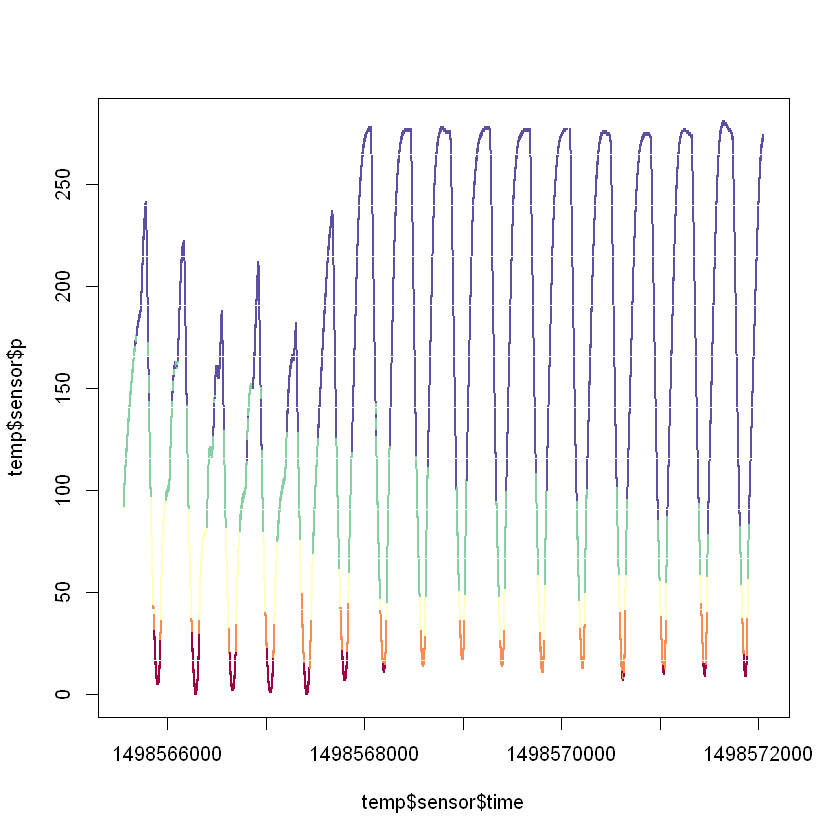

In [28]:
plot(temp$sensor$time, temp$sensor$p, pch=20, cex=0.3, col = make.div.pal(temp$sensor$t1, n = 5))

In [ ]:
plot(temp$time, temp$p, pch=20, cex=0.3)

In [5]:
check.bin = function(data, l = c(10000:135000)) {
    plot(data$sensor$time[l], data$sensor$p[l], type='l', ylab='Pressure', xlab='Time', ylim=c(100,0), yaxs='i')
    points(bin.data$sensor$time, bin.data$sensor$p, pch=4, cex=1.5, col='blue')
}

In [6]:
preprocess.files = function(input.dir, files, verbose = FALSE) {
    for (f in 1:length(files)) {
        if (verbose) {
            print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))
        }
        
        data = get.data(input.dir, files[f])
        #data$sensor = combine.data.sensor(data)
        #data = flag.p.outliers(data)
        n.before = nrow(data$sensor)
        
        if (verbose) {print('Binning the data.')}
        data = bin.p(data)
        #data = smooth.p(data)
        
        if (verbose) {print('Checkpoint Saved.')}
        if (verbose) {print('')}
        
        save(data, file = paste0('RStates/SeaSoar/Seasoar1-binned-', files[f], '.rdata'))
        
        if (verbose) {
            print(paste0('Number of Sensor Records before binning: ', n.before))
            print(paste0('Number of Sensor Records after binning: ', nrow(data$sensor)))
            print(paste0('(', floor(nrow(data$sensor)/n.before * 1000) / 10, '%)'))
        }
        print('')
    }
}

load.rstate = function(input.dir, files, verbose = TRUE) {
    compiled.data = NULL
    
    for (f in 1:length(files)) {
        if (verbose) {print(paste0('Starting file: ', files[f], ' (', f, ' of ', length(files), ')'))}
        load(file = paste0('RStates/SeaSoar/Seasoar1-binned-', files[f], '.rdata'))
        
        if (is.null(compiled.data)) {
            compiled.data = data
        } else {
            compiled.data$sensor = rbind(compiled.data$sensor, data$sensor)
            compiled.data$eng = rbind(compiled.data$eng, data$eng)
        }
        print(nrow(data$sensor))
    }
    compiled.data
}

In [7]:
preprocess.files(input.dir, files, verbose = TRUE)

[1] "Starting file: FLT_DAT001.mat (1 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 18785"
[1] "(12%)"
[1] ""
[1] "Starting file: FLT_DAT002.mat (2 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 42732"
[1] "(27.4%)"
[1] ""
[1] "Starting file: FLT_DAT003.mat (3 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 39503"
[1] "(25.3%)"
[1] ""
[1] "Starting file: FLT_DAT004.mat (4 of 50)"
[1] "Binning the data."
[1] "Checkpoint Saved."
[1] ""
[1] "Number of Sensor Records before binning: 155856"
[1] "Number of Sensor Records after binning: 35677"
[1] "(22.8%)"
[1] ""
[1] "Starting file: FLT_DAT005.mat (5 of 50)"
[1] "Binning the data."
[1] "Checkpoint Save

In [8]:
data = load.rstate(input.dir, files)

[1] "Starting file: FLT_DAT001.mat (1 of 50)"
[1] 18785
[1] "Starting file: FLT_DAT002.mat (2 of 50)"
[1] 42732
[1] "Starting file: FLT_DAT003.mat (3 of 50)"
[1] 39503
[1] "Starting file: FLT_DAT004.mat (4 of 50)"
[1] 35677
[1] "Starting file: FLT_DAT005.mat (5 of 50)"
[1] 31785
[1] "Starting file: FLT_DAT006.mat (6 of 50)"
[1] 27670
[1] "Starting file: FLT_DAT007.mat (7 of 50)"
[1] 29050
[1] "Starting file: FLT_DAT008.mat (8 of 50)"
[1] 26902
[1] "Starting file: FLT_DAT009.mat (9 of 50)"
[1] 23871
[1] "Starting file: FLT_DAT00A.mat (10 of 50)"
[1] 27913
[1] "Starting file: FLT_DAT00B.mat (11 of 50)"
[1] 30829
[1] "Starting file: FLT_DAT00C.mat (12 of 50)"
[1] 28646
[1] "Starting file: FLT_DAT00D.mat (13 of 50)"
[1] 37697
[1] "Starting file: FLT_DAT00E.mat (14 of 50)"
[1] 30374
[1] "Starting file: FLT_DAT00F.mat (15 of 50)"
[1] 35188
[1] "Starting file: FLT_DAT010.mat (16 of 50)"
[1] 33834
[1] "Starting file: FLT_DAT011.mat (17 of 50)"
[1] 31947
[1] "Starting file: FLT_DAT012.mat (18 o

In [9]:
conv.time = function(x, tz = 'UTC') {
    as.POSIXct(x, origin="1970-01-01", tz = tz)
}

add.times = function(data, tz = 'UTC') {
    data$sensor$time.real = as.POSIXct(data$sensor$time, origin="1970-01-01", tz = tz)
    data$eng$time.real = as.POSIXct(data$eng$time, origin="1970-01-01", tz = tz)
    
    data
}

In [10]:
for (i in 1:ncol(data$sensor)) {
    data$sensor[,i] = as.numeric(data$sensor[,i])
}
str(data)

List of 2
 $ eng   :'data.frame':	322428 obs. of  11 variables:
  ..$ lat        : num [1:322428] 34.2 34.2 34.2 34.2 34.2 ...
  ..$ lon        : num [1:322428] -121 -121 -121 -121 -121 ...
  ..$ time       : num [1:322428] 1.5e+09 1.5e+09 1.5e+09 1.5e+09 1.5e+09 ...
  ..$ cog        : num [1:322428] 314 305 304 310 318 ...
  ..$ sog        : num [1:322428] 1.4 1.6 1.6 1.4 1.4 1.5 1.5 1.3 1 0.8 ...
  ..$ heading    : num [1:322428] 325 325 325 326 326 ...
  ..$ sow        : num [1:322428] -99 -99 -99 -99 -99 -99 -99 -99 -99 -99 ...
  ..$ bottomdepth: num [1:322428] 729 729 729 732 732 ...
  ..$ moogdrive  : num [1:322428] 42 42 42 42 42 42 42 42 42 42 ...
  ..$ moogmonitor: num [1:322428] -108 -108 -108 -108 -108 ...
  ..$ tension    : num [1:322428] -1 2 -1 7 8 0 9 3 8 3 ...
 $ sensor:'data.frame':	1426160 obs. of  26 variables:
  ..$ t1         : num [1:1426160] 12.7 12.8 12.6 12.6 12.6 ...
  ..$ t2         : num [1:1426160] 12.7 12.7 12.7 12.8 12.8 ...
  ..$ p          : num [1:1426

In [11]:
data = add.times(data)

In [12]:
add.direction = function(data, p.min = 8, p.max = 250) {
    ## value codes
    ##   -1 = downcast
    ##   +1 = upcast
    ##    0 = ambiguous/outside bounds
    
    data$sensor$direction = 0
    dp = diff(data$sensor$p)
    
    l = which(dp < 0) # getting shallower
    data$sensor$direction[l+1] = 1
    
    l = which(dp > 0) # getting depper
    data$sensor$direction[l+1] = -1
    
    data$sensor$direction = runmed(data$sensor$direction, 21)
    data$sensor$direction[data$sensor$direction > 0] = 1
    data$sensor$direction[data$sensor$direction < 0] = -1
    
    data
}

In [13]:
data = add.direction(data)

In [14]:
plot(data$sensor$time, data$sensor$p)

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): unable to start png() device


plot without title

In [17]:
ss1 = data
save(ss1, file = '../../Data/CCEP1706_SeaSoar1.rdata')

In [ ]:
get.mld = function(data, rho = 0.1) {
    mld = data.frame(time = 0, lat = 0, lon = 0, mld = 0, stringsAsFactors = FALSE)
    
    ## Trim data to between 5db and 100db
    data$sensor = data$sensor[data$sensor$p > 5 & data$sensor$p < 100,]
    
    ## Find all the 10meter points on the downcast
    l = which(data$sensor$p == 10 & data$sensor$direction == -1)
    
    ## l should only include entries from different casts: here 10 minutes apart.
    dt = as.numeric(difftime(data$sensor$time.real[l], data$sensor$time.real[l[1]], units='mins'))
    l = l[c(1, which(diff(dt) > 10))]
    
    print(length(l))
    
    ## calculate mld and add to dataframe
    for (i in 1:length(l)) {
        t.10 = data$sensor$time.real[l[i]]
        rho.10 = data$sensor$sigma2[l[i]]
        
        ## define cast as within 3 minutes, downcast, pressure > 10, and afterwards
        l.time = which(as.numeric(difftime(data$sensor$time.real, t.10, unit='mins')) < 5 &
                       data$sensor$direction == -1 & data$sensor$p > 10 &
                       as.numeric(difftime(data$sensor$time.real, t.10, unit='mins')) > 0)
        
        if (length(l.time) > 15) {
            l.mld = min(which(data$sensor$sigma2[l.time] > rho.10 + rho))
            t.mld = data$sensor$time.real[l.time[l.mld]]

            eng = which.min(as.numeric(difftime(data$eng$time.real, t.10, units = 'mins'))^2)
            mld = rbind(mld, c(t.mld, data$eng$lat[eng], data$eng$lon[eng], data$sensor$p[l.time[l.mld]]))
        }
    }
    
    mld = mld[-1,]
    mld$time = conv.time(mld$time)
    mld
}

In [ ]:
mld = get.mld(data, 0.1)
mld2 = get.mld(data, 0.2)

In [ ]:
#plot(data$sensor$time.real, data$sensor$p, cex=0.1, pch=20, col=get.qual.pal(3)[data$sensor$direction+2],
#     ylim=c(300,0), yaxs='i', ylab='Depth', xlab='')
plot(data$sensor$time.real[c(1, nrow(data$sensor))], data$sensor$p[c(1, nrow(data$sensor))], cex=0.1, pch=20, col='white',
     ylim=c(100,0), yaxs='i', ylab='Depth', xlab='')

points(mld$time, mld$mld, pch=15, col='dark red')
points(mld2$time, mld2$mld, pch=16, col='dark blue', cex=0.5)
lines(c(min(mld$time), max(mld$time)), c(10,10), lty=2)

In [ ]:
plot.map(lon = mld$lon, lat = mld$lat, main = 'SeaSoar MLDs', col = make.div.pal(mld$mld, 100))

In [ ]:
seasoar2 = mld
save(seasoar2, file = 'RStates/SeaSoar2.MLD (0.1).rdata')

In [ ]:
save(data, file='RStates/SeaSoar2.final.rdata')

---
# Review

In [ ]:
plot.mld = function(mld, i, window = 3) {
    l = which(as.numeric(difftime(data$sensor$time.real, mld$time[i], units = 'mins')) < window &
              as.numeric(difftime(data$sensor$time.real, mld$time[i], units = 'mins')) >= -window &
             data$sensor$direction == -1)
    
    plot(data$sensor$sigma2[l], data$sensor$p[l], ylim=c(100,0), xlim=c(1023,1027), yaxs='i',
         pch=20, col='#00000050', cex=1, main=paste0(i, ' - ', length(l)), ylab='Depth', xlab='Density')
    
    lines(c(0,10000), rep(mld$mld[i], 2), lty=2, col='red')
    #lines(c(0,10000), rep(mld2$mld[i], 2), lty=1, col='red')
    lines(c(0,10000), rep(10, 2), lty=2, col='blue')
    
    text(1023, 80, mld$mld[i])
}

In [ ]:
pdf('Output/SeaSoar2 - MLD Review (0.2).pdf')

par(mfrow=c(2,2))
for(i in 1:nrow(mld2)) {
    plot.mld(mld2, i)
}

dev.off()